In [139]:
D = 3
R = 2 ** 8

In [140]:
from sklearn.utils import murmurhash3_32
import random
import sys

random.seed(13)

def h(x, seed, R):
    return murmurhash3_32(key=x, seed=seed) % R

class CountMinSketch:
  def __init__(self, d: int, R: int):
    self.d = d
    self.R = R
    self.array = []

    for _i in range(d):
      self.array.append([0] * R)

  def insert(self, token: str):
    for i in range(self.d):
      hash = h(token, i, self.R)
      self.array[i][hash] += 1

  def query(self, token: str):
    res = []
    for i in range(self.d):
      hash = h(token, i, self.R)
      res.append(self.array[i][hash])
    return min(res)
  
  def get_memory_usage(self):
    memory = sys.getsizeof(self)
    for subarray in self.array:
      memory += sys.getsizeof(subarray)
    return memory

In [141]:
from collections import defaultdict

class CountMinSketchWithOracle(CountMinSketch):
  def __init__(self, d: int, R: int, oracle: callable):
    super().__init__(d, R)
    self.oracle = oracle
    self.heavy_hitter_counts = defaultdict(int)
  def insert(self, token: str):
    if token in self.heavy_hitter_counts or self.oracle(token) == 1:
      self.heavy_hitter_counts[token] += 1
    else:
      super().insert(token)
  def query(self, token: str):
    if token in self.heavy_hitter_counts:
      return self.heavy_hitter_counts[token]
    else:
      return super().query(token)

In [142]:
# sketch = CountMinSketch(10, 2 ** 20)
# sketch.insert("Taha")
# sketch.insert("Hi")
# sketch.insert("Taha")
# print(sketch.query("Taha"))
# print(sketch.query("Hi"))
# print(sketch.query("Teet"))

In [143]:
# oracle_sketch = CountMinSketchWithOracle(5, 2 ** 16, lambda x: 1 if x == "Taha" else 0)
# oracle_sketch.insert("Taha")
# oracle_sketch.insert("hi")
# print(oracle_sketch.query("Taha"))
# print(oracle_sketch.query("hi"))
# print(oracle_sketch.query("hsi"))

In [144]:
import pandas as pd

# Data collection and pre-processing
data = pd.read_csv('user-ct-test-collection-01.txt', sep="\t")
urllist = list(data.ClickURL.dropna())

In [145]:
import itertools

# Data collection and pre-processing
data = pd.read_csv('user-ct-test-collection-01.txt', sep="\t")
queries = data.Query.dropna()
queries = map(lambda x: x.split(" "), queries)
queries = list(itertools.chain.from_iterable(queries))

In [146]:
from collections import Counter 

url_freq = Counter(urllist)

In [147]:
tokens_freq = Counter(queries)

In [148]:
print(tokens_freq.most_common(200))

[('of', 110575), ('-', 104052), ('in', 91521), ('the', 82961), ('for', 70107), ('and', 66675), ('to', 45168), ('free', 45149), ('a', 36220), ('google', 34970), ('new', 26856), ('http', 24394), ('on', 24113), ('yahoo', 23491), ('county', 22435), ('pictures', 21416), ('how', 19377), ('my', 19082), ('lyrics', 18476), ('school', 18091), ('myspace', 16549), ('sex', 16511), ('florida', 15779), ('ebay', 15603), ('com', 15051), ('sale', 14612), ('american', 14479), ('city', 14331), ('with', 14228), ('home', 13794), ('state', 13622), ('what', 12466), ('is', 12252), ('www', 12171), ('music', 12161), ('pics', 11704), ('.com', 11691), ('games', 11639), ('york', 11556), ('i', 11234), ('girls', 10980), ('beach', 10887), ('bank', 10707), ('texas', 10666), ('online', 10664), ('black', 10567), ('high', 10506), ('nude', 10457), ('by', 10118), ('aol', 10083), ('yahoo.com', 10007), ('map', 9791), ('you', 9666), ('news', 9614), ('myspace.com', 9577), ('porn', 9569), ('college', 9510), ('from', 9178), ('at'

In [149]:
print(tokens_freq.most_common(100))

[('of', 110575), ('-', 104052), ('in', 91521), ('the', 82961), ('for', 70107), ('and', 66675), ('to', 45168), ('free', 45149), ('a', 36220), ('google', 34970), ('new', 26856), ('http', 24394), ('on', 24113), ('yahoo', 23491), ('county', 22435), ('pictures', 21416), ('how', 19377), ('my', 19082), ('lyrics', 18476), ('school', 18091), ('myspace', 16549), ('sex', 16511), ('florida', 15779), ('ebay', 15603), ('com', 15051), ('sale', 14612), ('american', 14479), ('city', 14331), ('with', 14228), ('home', 13794), ('state', 13622), ('what', 12466), ('is', 12252), ('www', 12171), ('music', 12161), ('pics', 11704), ('.com', 11691), ('games', 11639), ('york', 11556), ('i', 11234), ('girls', 10980), ('beach', 10887), ('bank', 10707), ('texas', 10666), ('online', 10664), ('black', 10567), ('high', 10506), ('nude', 10457), ('by', 10118), ('aol', 10083), ('yahoo.com', 10007), ('map', 9791), ('you', 9666), ('news', 9614), ('myspace.com', 9577), ('porn', 9569), ('college', 9510), ('from', 9178), ('at'

In [150]:
freq_tokens = tokens_freq.most_common(100)
infreq_tokens = tokens_freq.most_common()[:-101:-1]
random_tokens = random.sample(tokens_freq.items(), 100)

/var/folders/4n/ghvzsdpj5nq5mtt0z1brxsm00000gn/T/ipykernel_21958/737723934.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_tokens = random.sample(tokens_freq.items(), 100)


In [151]:
sketch = CountMinSketch(D, R)

In [152]:
for query in queries:
    sketch.insert(query)

In [153]:
def perfect_oracle(token):
    if token in tokens_freq and tokens_freq[token] >= 1000:
        return 1
    else: 
        return 0
sketch_with_oracle = CountMinSketchWithOracle(D, R, perfect_oracle)

In [154]:
for query in queries:
    sketch_with_oracle.insert(query)

In [155]:
from statistics import mean

def mean_error(sketch, token_counts):
    errors = []
    for token, actual_count in token_counts:
        estimated_count = sketch.query(token)
        errors.append(abs(estimated_count - actual_count)/actual_count)
    return mean(errors)

In [156]:
print("Mean error with Min Sketch:", mean_error(sketch, tokens_freq.items()))
print("Mean error with Min Sketch With Learned Oracle:", mean_error(sketch_with_oracle, tokens_freq.items()))

Mean error with Min Sketch: 17604.789679721885
Mean error with Min Sketch With Learned Oracle: 11641.387179602742


In [157]:
import matplotlib.pyplot as plt

def plot_errors(sketch, sketch_with_oracle, token_counts, title=""):

  min_sketch_errors = []
  sketch_with_oracle_errors = []

  for token, actual_count in token_counts:
    estimated_count = sketch.query(token)
    min_sketch_errors.append(abs(estimated_count - actual_count)/actual_count)

    estimated_count = sketch_with_oracle.query(token)
    sketch_with_oracle_errors.append(abs(estimated_count - actual_count)/actual_count)

  plt.plot(min_sketch_errors, label = "Count Min Sketch")
  plt.plot(sketch_with_oracle_errors, label = "Count Min Sketch With Oracle")
  plt.xlabel("Token")
  plt.ylabel("Error")
  plt.title(title)
  plt.legend()
  plt.show()

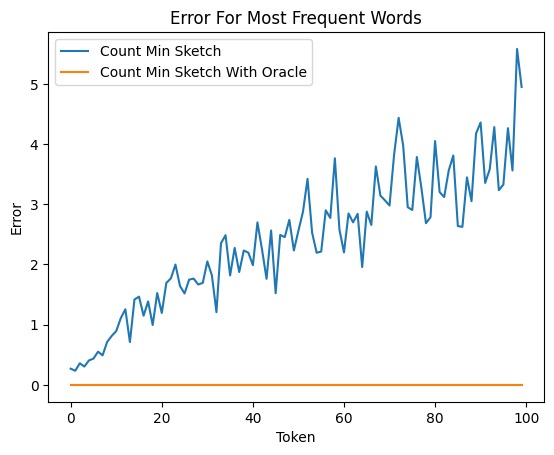

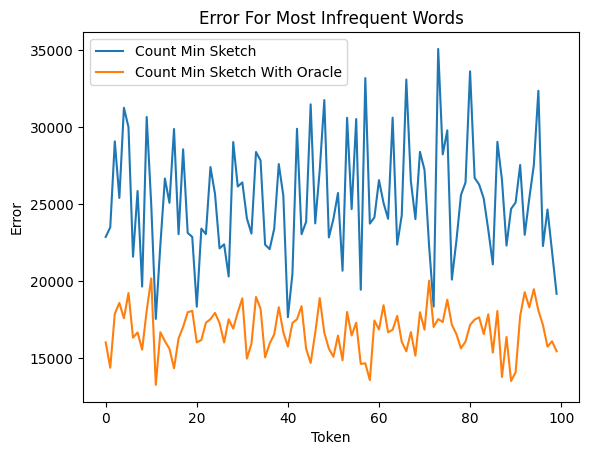

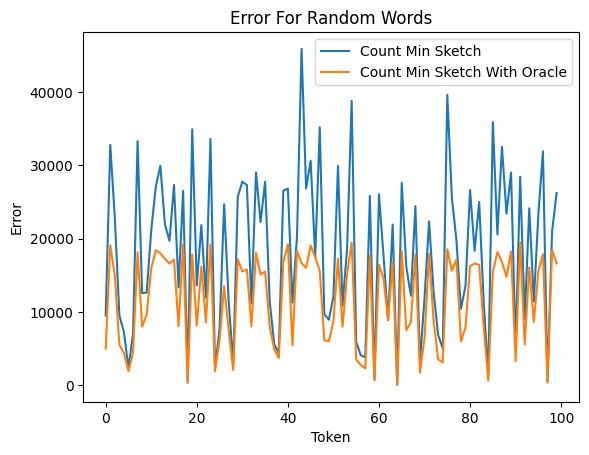

In [158]:
plot_errors(sketch, sketch_with_oracle, freq_tokens, "Error For Most Frequent Words")
plot_errors(sketch, sketch_with_oracle, infreq_tokens, "Error For Most Infrequent Words")
plot_errors(sketch, sketch_with_oracle, random_tokens, "Error For Random Words")